# Load Libraries

In [1]:
%run "00 - PSO Data Load Basic lib.ipynb"

## Load XML Records of interest <b>from a file</b>

In [14]:
file_to_parse = '..\\data\\DataAnalysisDemo.xml' # schedule exported from OSV PSO end of day for the simulations

# Parse the XML file and create the DataFrame
df_activities = parse_records_to_dataframe_by_file(file_to_parse,'Activity')
df_activities_sla = parse_records_to_dataframe_by_file(file_to_parse,'Activity_SLA')
df_plan_travel = parse_records_to_dataframe_by_file(file_to_parse,'Plan_Travel')
df_locations = parse_records_to_dataframe_by_file(file_to_parse,'Location')
df_allocations = parse_records_to_dataframe_by_file(file_to_parse,'Allocation')


## Build a fact table for Activities joining more dataframes

In [15]:
# Create a dataframe of activities selecting from df_activities the columns: id, activity_type_id, location_id, duration and renaming id to activity_id
df_fact_activities = df_activities[[
    'id', 'activity_type_id', 'location_id', 'duration']].rename(columns={'id': 'activity_id'})

# join df_fact_activities with df_activities_sla by activity_id where sla_type_id is 'Normal'
df_fact_activities = pd.merge(
    df_fact_activities, df_activities_sla[df_activities_sla['sla_type_id'] == 'Default'][[
        'activity_id', 'datetime_start', 'datetime_end']], how='left', left_on='activity_id', right_on='activity_id')

# join df_fact_activities with df_locations by location_id and select columns latitude, longitude and city
df_fact_activities = pd.merge(
    df_fact_activities, df_locations[[
        'id', 'latitude', 'longitude']], how='left', left_on='location_id', right_on='id')


# join df_fact_activities with df_allocations by activity_id and select columns resource_id, activity_start, activity_end

df_fact_activities = pd.merge(
    df_fact_activities, df_allocations[[
        'activity_id','resource_id', 'activity_start', 'activity_end']], how='left', left_on='activity_id', right_on='activity_id')

# join df_fact_activities with df_plan_travel by activity_id and select columns shift_start_datetime, shift_end_datetime, shift_start_time, shift_end_time, shift_start_date and shift_end_date

# and remove the id column from df_fact_activities
df_fact_activities = df_fact_activities.drop(['id'], axis=1)

# Convert expected_travel_time from ISO 8601 format to timedelta
df_plan_travel['expected_travel_time'] = df_plan_travel['expected_travel_time'].apply(
    isodate.parse_duration)

# Calculate the difference between end_time and start_time and day of the shift
df_plan_travel['real_travel_time'] = (
    df_plan_travel['end_time'] - df_plan_travel['start_time'])
df_plan_travel['shift_day'] = df_plan_travel['shift_start_datetime'].dt.date

# join df_fact_activities with df_plan_travel by activity_id and select distance, expected_travel_time, real_travel_time and shift_day
df_fact_activities = pd.merge(df_fact_activities, df_plan_travel[[
                              'activity_id', 'distance', 'expected_travel_time', 'real_travel_time', 'shift_day']], how='left', left_on='activity_id', right_on='activity_id')

## Data Cleansing and Filtering

In [16]:
# Remove from fact_activities the rows where activity_type_id is 'EV_CHARGER' and 'VACATION'
df_filtered_fact_activities = df_fact_activities[df_fact_activities['activity_type_id']!= 'EV_CHARGER']
df_filtered_fact_activities = df_filtered_fact_activities[df_fact_activities['activity_type_id']!= 'VACATION']


# Plot a Pie Chart with seaborn from df_filtered_fact_activities by activity_type_id

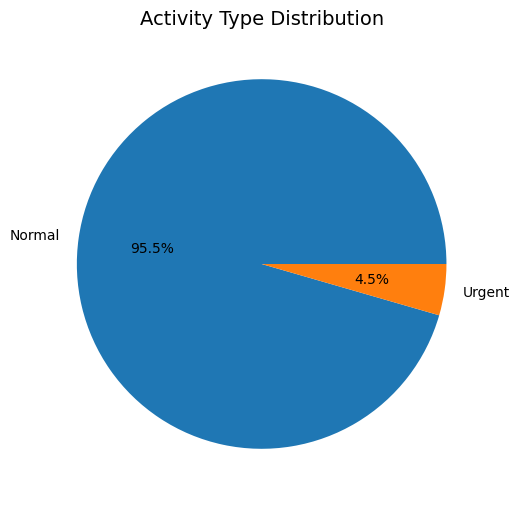

In [17]:
# plot a nice pie chart with seaborn from df_filtered_fact_activities by activity_type_id

fig, ax = plt.subplots(figsize=(10, 6))
ax.pie(df_filtered_fact_activities['activity_type_id'].value_counts(), labels=df_filtered_fact_activities['activity_type_id'].value_counts().index, autopct='%1.1f%%')
ax.set_title('Activity Type Distribution', fontsize=14)
plt.show()


# Plot Map of Activities

In [18]:
import folium
from folium.plugins import MarkerCluster

# Coordinates for the center in Raleigh
map_center = [35.7930215,-78.6621723]

# Create a Folium map centered 
map = folium.Map(location=map_center, zoom_start=10)

#map

In [19]:
#Get latitude and longitude
locations_data = np.array(df_filtered_fact_activities[['latitude','longitude']].astype(float))
popups_data = ["lon:{}<br>lat:{}".format(longitude, latitude) for (longitude,latitude) in np.array(df_filtered_fact_activities[['longitude', 'latitude']])]

# Create the Marker
marker_cluster = MarkerCluster(locations=locations_data,popups=popups_data)
marker_cluster.add_to(map)

map

## Plot the time difference between actual and expected travel time

In [20]:
# Group by resource_id and calculate the total time difference for each resource
# remove from df_filtered_fact_activities rows where resource_id is Nan

df_filtered_fact_activities['resource_id']= df_filtered_fact_activities['resource_id'].fillna('')
#df_filtered_fact_activities_2Xtechs = df_filtered_fact_activities[df_filtered_fact_activities['resource_id'].str.contains('(R2)',regex=True)]
filtered_grouped_df = df_filtered_fact_activities.groupby(['resource_id','shift_day'])[['real_travel_time','expected_travel_time']].sum().reset_index()

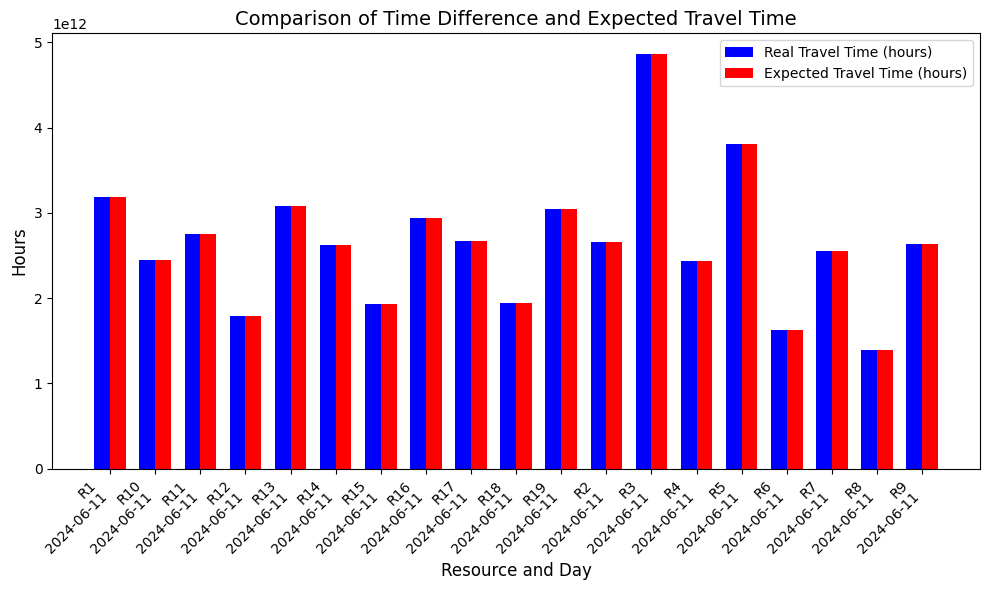

In [21]:
# Plotting the histogram
fig, ax = plt.subplots(figsize=(10, 6))

# Create bar plots
bar_width = 0.35
bar_positions = list(range(len(filtered_grouped_df)))

# Plot time differences
ax.bar(bar_positions, filtered_grouped_df['real_travel_time'], width=bar_width, label='Real Travel Time (hours)', color='b')

# Plot expected travel times
ax.bar([p + bar_width for p in bar_positions], filtered_grouped_df['expected_travel_time'], width=bar_width, label='Expected Travel Time (hours)', color='r')

# Set the labels and title
ax.set_xlabel('Resource and Day', fontsize=12)
ax.set_ylabel('Hours', fontsize=12)
ax.set_title('Comparison of Time Difference and Expected Travel Time', fontsize=14)
ax.set_xticks([p + bar_width / 2 for p in bar_positions])
#ax.set_xticklabels([f"{row['resource_id']}\n{row['shift_day']}" for _, row in grouped_df.iterrows()])
ax.set_xticklabels([f"{row['resource_id']}\n{row['shift_day']}" for _, row in filtered_grouped_df.iterrows()], fontsize=10, rotation=45, ha='right')
ax.legend()

# Display the plot
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

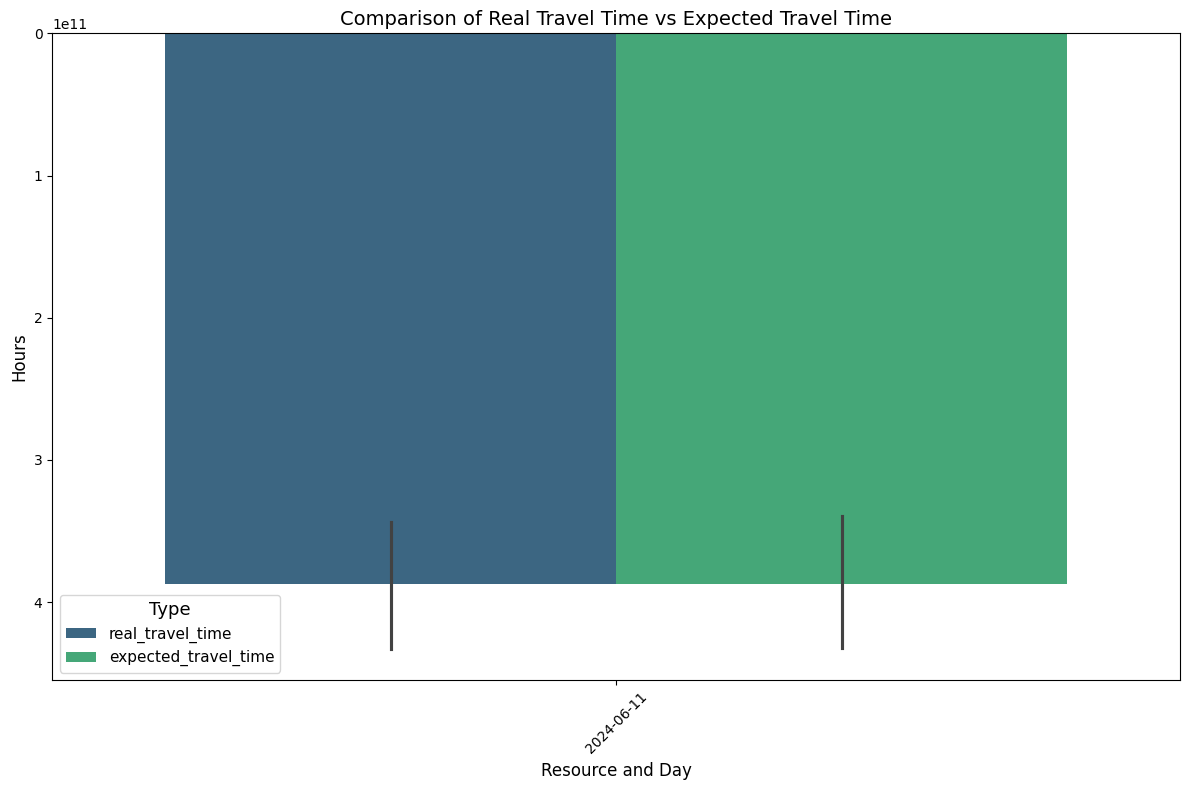

In [23]:
# Melt the DataFrame for seaborn
melted_df = df_filtered_fact_activities.melt(id_vars=['resource_id', 'shift_day'], 
                            value_vars=['real_travel_time', 'expected_travel_time'], 
                            var_name='Type', value_name='Hours')

# Plotting with seaborn
plt.figure(figsize=(12, 8))
sns.barplot(data=melted_df, x='shift_day', y='Hours', hue='Type', palette='viridis')

# Customize the plot
plt.xlabel('Resource and Day', fontsize=12)
plt.ylabel('Hours', fontsize=12)
plt.title('Comparison of Real Travel Time vs Expected Travel Time', fontsize=14)
plt.xticks(rotation=45)
plt.legend(title='Type', title_fontsize='13', fontsize='11')

# Display the plot
plt.tight_layout()
plt.show()